## Some Code for Computer Exercise #06  ###

Common Imports

In [121]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

Read the data in subdirectory ``data`` and save it as a pandas dataframe.

In [9]:
data_train = pd.read_csv('train.csv', dtype=int) # read train data
data_test = pd.read_csv('test.csv', dtype=int)   # read test data

### Questions pp.1-2

1. There are 60000 images in the dataset and the classes are perfectly balanced.
2. The features are pixel1 - pixel784 and the outcome feature is label which takes a value between [0,9] inclusive.
3. The dimensions of the features are 60,000 x 784 with each feature being able to take a value between [0,255] inclusive. This means the feature space is $256^{784}$.
4. See the figure below for an example of each image in the binary color mapping.

In [15]:
print(data_train.head())
print(data_test.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [134]:
check_labels = data_train.iloc[:,0].to_numpy()
print(np.unique(check_labels, return_counts=True))
print(f"There are {len(data_train)} images in the training dataset")
print(f"There are {len(data_test)} images in the test dataset")
data_train.info()
data_train.columns
max_vals = data_train.iloc[:,1:].max()
min_vals = data_train.iloc[:,1:].min()
print(max(max_vals))
print(min(min_vals))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
There are 60000 images in the training dataset
There are 10000 images in the test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
255
0


Prepare the data and put it into arrays ``X_train``, ``y_train`` and ``X_test``, ``y_test``.

In [28]:
X_train = data_train.drop('label', axis=1)
y_train = data_train['label']
X_test = data_test.drop('label', axis=1)
y_test = data_test['label']

Display the $i^{th}$ image in the dataset.

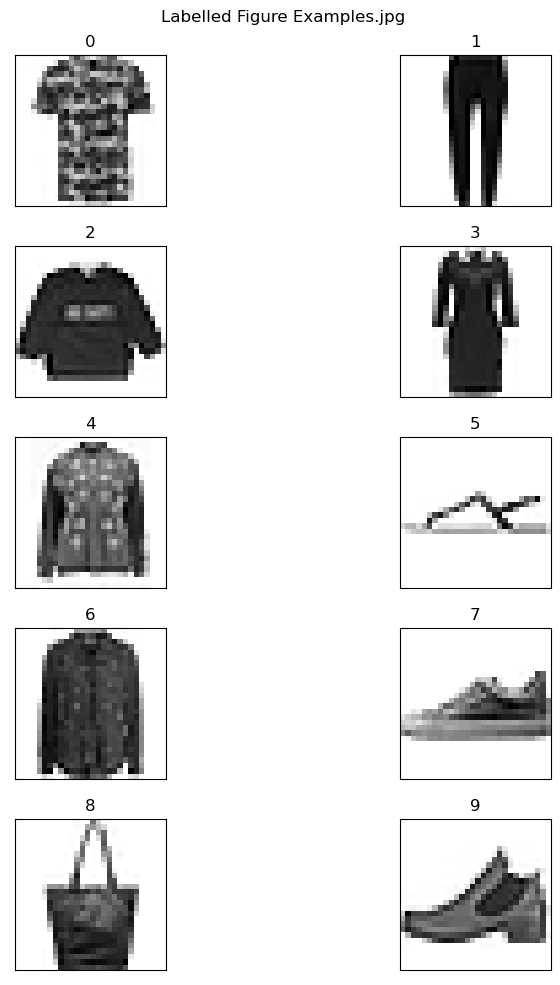

In [58]:
# Loop through labels and pick index to fill
label_idx = {}
for i,j in enumerate(y_train):
    if j not in label_idx:
        label_idx[j] = i

fig, axs = plt.subplots(5,2, figsize=(10,10))

for row in range(5):
    for col in range(2):
        axs[row,col].imshow(X_train.iloc[label_idx[row*2 + col],:].values.reshape([28,28]), cmap="binary") 
        axs[row,col].set_title(f"{row*2 + col}")
        axs[row,col].set_xticks([])
        axs[row,col].set_yticks([])
plt.suptitle("Labelled Figure Examples.jpg")
plt.tight_layout()
plt.savefig("labelled_figure_example.jpg")
plt.show()


## Decision Tree ##
Here is the basic call to learn a decision tree using the default values on the data ``[X_train,y_train]``. 

In [84]:
Tree_model = DecisionTreeClassifier(random_state = 42).fit(X_train,y_train)

### Questions p.3 (Assignment is number 5)
1. The default values for the decision tree is Gini impurity, a minimum of 2 samples in a nodes are required to split, the minimum number of samples for a node to be considered a leaf is 1, and the maximum depth is unconstrained.
2. The number of leaves in the tree is 4993 and the leaves are fully pure. The maximum depth of the tree 48.
3. The accuracy of the model on the training data is 1. This means the trees perfectly models the training data. This is unsurprising because the tree is grown unregularized so it grows to full depth to fully model the data.
4. The test score is 0.8. This tells me the model is overfitting the data.
5. The confusion matrix is shown below. It looks like the tree is having difficulty classifying (0,6), (4,2), (2,6), and (4,6).

In [85]:
print(f"The number of leaves is {Tree_model.get_n_leaves()}")
print(f"The max depth is {Tree_model.get_depth()}")
print(f"The leaf purity can be deduced from the training score {Tree_model.score(X_train,y_train)}")
print(f"The test score is: {Tree_model.score(X_test,y_test)}")

The number of leaves is 4993
The max depth is 48
The leaf purity can be deduced from the training score 1.0
The test score is: 0.7963


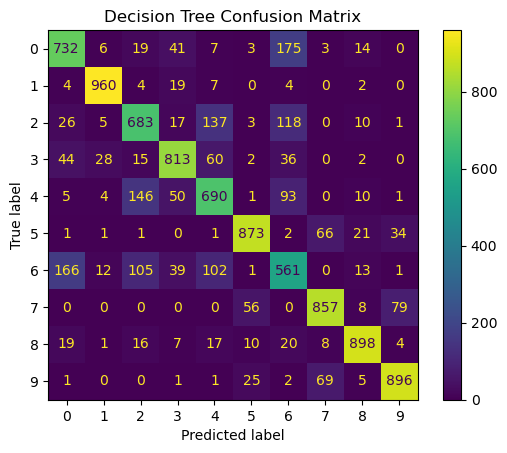

In [86]:
y_pred = Tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Decision Tree Confusion Matrix")
disp.figure_.savefig('decision_tree_confusion_matrix.png')

### Cross-Validation ###

### Assignment p.3
I used the ShuffleSplit class. I did this to shuffle the training data so any underlying correlations with the way the data were entered are broken. I used a test size of 0.2 and did 5 fold cross validation. I chose 5 folds because of CPU constraints on my computer. Because I used the ShuffleSplit generator I was able to directly control the test size unlike inputting an integer to the cv paramter in the cross_val_score method. The advtange of using 10 folds is that you have a better estimate of the error on the dataset. Additionally, a larger number of folds allows the estimator to be trained on more data generally leading to a better predictor. Using the default scoring parameter uses the estimator's default scoring metric. The estimated expected error is 0.21.

In [91]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)
all_accuracies = cross_val_score(estimator=Tree_model, X=X_train, y=y_train, cv=cv)

#### Print accuracies

In [92]:
print(all_accuracies)
print('Mean Accuracy %8.2f' %(all_accuracies.mean()))

[0.78641667 0.797      0.79566667 0.79333333 0.79358333]
Mean Accuracy     0.79


### Assignment p.4
1. The training error of the estimator is 12.4 percent.
2. I used the same cross validation Shuffle Split class as described above and found the estimated expected eror (1 - cv_score_mean) is 19 percent.
3. The confusion matrix is shown below. The confusion matrix shows similar patterns to the first decision matrix. The sum of the diagonals is larger than the original matrix which reflects the increased accuracy of the regularized tree. The decision tree is having similar problems with classes (0,6), (4,2), (2,6), and (4,6). However, there is a slight improvement especially (2,6) and (4,6). This makes sense because we didn't change the way the tree would learn the classes to focus on these problem areas. 

In [93]:
Tree_model_5_12 = DecisionTreeClassifier(min_samples_leaf = 5, max_depth = 12, random_state = 42).fit(X_train,y_train)

In [96]:
cv_acc_5_12 = cross_val_score(estimator=Tree_model_5_12, X=X_train, y=y_train, cv=cv)

In [97]:
print(f"The train error is: {1- Tree_model_5_12.score(X_train, y_train)}")
print(f"The estimaed expected error is {1 - cv_acc_5_12.mean()}")

The train error is: 0.12403333333333333
The estimaed expected error is 0.18584999999999996


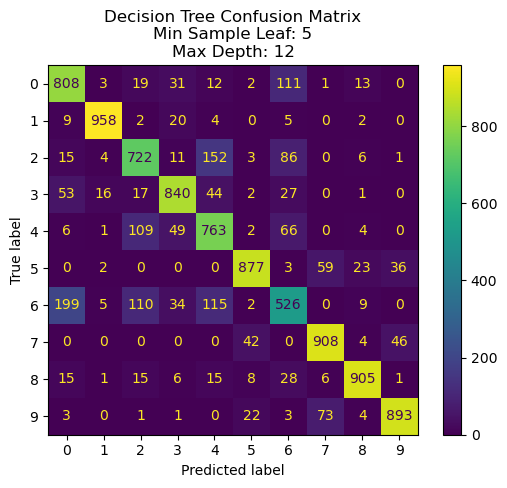

In [100]:
y_pred_5_12 = Tree_model_5_12.predict(X_test)
cm_5_12 = confusion_matrix(y_test, y_pred_5_12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_5_12)
disp.plot()
disp.ax_.set_title("Decision Tree Confusion Matrix\nMin Sample Leaf: 5\nMax Depth: 12")
disp.figure_.savefig('decision_tree_5_12_confusion_matrix.png')

### Assignment p.5
Searching the hyperparameters I did not search over the purity criterion because Gini and Entropy result in similar trees so I didn't see the need to spend CPU resources on a procedures that would result in similar trees. I included min_samples_split as a third hyperparameter to search through. I searched through 'min_samples_leaf':[20, 30, 40], 'max_depth':[5, 10, 15], 'min_samples_split': [2, 8]. The smaller search space and choosing parameters that result in shallower trees/less splits were chosen due to resource constraints. The best set of parameters was a max depth of 15, minimum samples in a leaf of 20, and minimum samples in a split of 2 which resulted in a best score of 81%. The best parameters are all instances where the tree is trying to grow deeper and split nodes more often which leads me to believe the model is underfitting.

In [103]:

grid_param = { 'min_samples_leaf':[20, 30, 40], 'max_depth':[5, 10, 15], 'min_samples_split': [2, 8]}
gd_sr = GridSearchCV(estimator=Tree_model, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)
best_result = gd_sr.best_score_
print(best_result)

{'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 2}
0.8104833333333333


### Assignment p. 6 - Random Forest
I reduced the number of estimators to 100 due to CPU resource constraints. I left the impurity measure as Gini. From growing decision trees above we know the max depth is 48 for a fully grown tree. To increase the variance while balancing the computational constraints I set max_depth to 22. I increased the max features to 50, the square root of the feature space is 28. Increasing this value should allow the tree to find better split points.

1. The training error of the classifier is 99 percent while the out of bag score is 88 percent. This suggests the classifier is overfitting the data.
2. I ran a grid search over 'n_estimators':[100, 150], 'max_depth': [20, 25], 'max_features': ['sqrt', 60]. I believe the increase in depth coupled with more trees will provide a better estimator because deeper trees will have lower bias but increased variance and this will be balanced with more estimators hopefully lowering the overall variance in the ensemble. Due to CPU resource constraints, this grid search was run through Google Colab. The best collection of parameters is max depth 25, max features 60, and 150 estimators. This shows the rnadom forest gets better as the complexity increases as long as the number of estimators increases.
3. The computational complexity is massive. Running this grid search takes 1 hour and 45 minutes on Google Colab which has higher processing power than my personal computer yet I was able to run the decision trees with a larger grid faster. The performance of this classifer is 88 percent with parameters max depth 25, max features 60, and 150 estimators. Compared to the extra random forest this has much higher time complexity which is expected because the features have to be searched for optimal split points unlike the extra tree which has random splits.

In [109]:
forest_clf = RandomForestClassifier(n_estimators=100, max_depth = 22, max_features = 50, oob_score=True)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=22, max_features=50, oob_score=True)

In [110]:
print(f"The training score is: {forest_clf.score(X_train,y_train)}")
print(f"The out of bag score is: {forest_clf.oob_score_}")

The training score is: 0.9953833333333333
The out of bag score is: 0.8808333333333334


In [ ]:
### RUN ON COLAB
grid_param_rf = {'n_estimators':[100, 150], 'max_depth': [20, 25], 'max_features': ['sqrt', 60]}
gd_sr_rf = GridSearchCV(estimator=forest_clf, param_grid=grid_param_rf, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr_rf.fit(X_train, y_train)
best_parameters_rf = gd_sr_rf.best_params_
print(best_parameters_rf)
best_result_rf = gd_sr_rf.best_score_
print(best_result_rf)

### Assignment p. 6 - Extra Trees

1. As with the Random Forest I began with 100 estimators. I used a max depth of 28 to allow the tree to grow slightly deeper than the random forest due to the addition of the random split points, and I upped the max features to 50. I did not bootstrap the samples because this is not the traditional way Extra Trees are grown, thus I did not have out of bag samples. The training error of the extra tree is 0 and the 5 fold, 20% train size cross validation accuracy is 0.88
2. To test the random forest I ran a grid search over 'n_estimators':[100, 150], 'max_depth': [15, 25], 'max_features': ['sqrt', 60]. The best estimator had max depth 25, max features 60, and 150 estimators. This validates my assumption that growing deeper, more complex trees and balancing them out with more estimators results in better models. The best accuracy was 88 percent. 

In [114]:
et_clf = ExtraTreesClassifier(n_estimators=100, max_depth=28, min_samples_split=2, max_features = 50)
et_clf.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=28, max_features=50)

In [128]:
print(f"The train accuracy is {et_clf.score(X_train, y_train)}")
cv_et = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)
all_accuracies_et = cross_val_score(estimator=et_clf, X=X_train, y=y_train, cv=cv_et)
print(f"The cross validation score is {all_accuracies_et.mean()}")

The train accuracy is 1.0
The cross validation score is 0.8818666666666667


In [120]:
grid_param_et = {'n_estimators':[100, 150], 'max_depth': [15, 25], 'max_features': ['sqrt', 60]}
gd_sr_et = GridSearchCV(estimator=et_clf, param_grid=grid_param_et, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr_et.fit(X_train, y_train)
best_parameters_et = gd_sr_et.best_params_
print(best_parameters_et)
best_result_et = gd_sr_et.best_score_
print(best_result_et)

{'max_depth': 25, 'max_features': 60, 'n_estimators': 150}
0.8838333333333335


### Assignment p.7 - AdaBoost
1. Done
2. The accuracy of the 3000 estimator model on the training data is 47 percent. I used a 3 fold cross validation and increased the test size is 40%. This was done due to the long run times of the estimator. The cross validation accuracy is [XX]. With the accuracies this low the estimator is severly underfitting the data.
3. To try and deal with the underfitting I ran a grid search increasing the depth of the base learner and scaling back the number of estimators, and tried different learning rates. I ran the grid search over the following parameters: 'n_estimators':[100, 500], 'learning_rate': [1.0, 2.0], 'estimator':[adab_tree_2, adab_tree_4] where adab_tree_n is a depth 2 or 4 tree respectively. Using this methodology the best tree depth is 4, a learning rate of 1, and 500 estimators which resulted in a cross validation score of 74 percent. This shows the tree depth is a very important parameter and seemingly more important than the number of estimators.
4. It seems like the number of estimators makes a significant impact on the algorithm especially runtime. As mentioned above, less estimators and a deeper tree had significantly higher accuracy which makes me think that a decision stump is too weak of a learner to properly classify the dataset. This makes me think a larger number of estimators and a slightly deeper tree would perform even better.

In [123]:
ada_clf = AdaBoostClassifier(n_estimators=3000, random_state=42, algorithm = 'SAMME.R')
ada_clf.fit(X_train, y_train)

/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=3000, random_state=42)

In [131]:
print(ada_clf.score(X_train,y_train))
cv_adab = ShuffleSplit(n_splits = 3, test_size = 0.4, random_state = 42)
all_accuracies_adab = cross_val_score(estimator=ada_clf, X=X_train, y=y_train, cv=cv_adab)
print(f"The accuracy of the cross validated adaboost is: {all_accuracies_adab.mean()}")

0.46781666666666666


/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


The accuracy of the cross validated adaboost is: 0.4967916666666667


In [130]:
adab_tree_2 = DecisionTreeClassifier(random_state = 42, max_depth = 2)
adab_tree_4 = DecisionTreeClassifier(random_state = 42, max_depth = 4)
grid_param_adab = {'n_estimators':[100, 500], 'learning_rate': [1.0, 2.0], 'estimator':[adab_tree_2, adab_tree_4]}
gd_sr_adab = GridSearchCV(estimator=ada_clf, param_grid=grid_param_adab, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr_adab.fit(X_train, y_train)
best_parameters_adab = gd_sr_adab.best_params_
print(best_parameters_adab)
best_result_adab = gd_sr_adab.best_score_
print(best_result_adab)

/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/acard36/opt/anaconda3/envs/help_me/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

{'estimator': DecisionTreeClassifier(max_depth=4, random_state=42), 'learning_rate': 1.0, 'n_estimators': 500}
0.7365333333333333


### Assignment p.8 - Gradient Boosting

Due to the size of the dataset I used the HistGradientBoostingClassifier. In the documentation for GradientBoostingClassifier it is recommended to use this class for datasets larger than 10,000 samples. Additionally, I ran the grid search on Google Colab to improve the processing power due to the computation restraints of my personal computer. I used 'learning_rate': [0.1, 0.6], 'max_depth': [ 3], 'max_iter': [100, 300] and the best parameters were a learning rate of 0.1 and max iterations of 300. This resulted in a cross validation score of 89%. This has a slightly higher accuracy than any other model and has a fairly low time complexity.

In [ ]:
###### RUN ON COLAB
grid_param_gb = {'learning_rate': [0.1, 0.6], 'max_depth': [1, 3], 'max_iter': [100, 300]}
gb_clf = HistGradientBoostingClassifier(random_state=42)
gd_sr_gb = GridSearchCV(estimator=gb_clf, param_grid=grid_param_gb, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr_gb.fit(X_train, y_train)
best_parameters_gb = gd_sr_gb.best_params_
print(best_parameters_gb)
best_result_gb = gd_sr_gb.best_score_
print(best_result_gb)

### Final Evaluation p.8

In [132]:
final_eval = ExtraTreesClassifier(n_estimators=150, max_depth=25, min_samples_split=2, max_features = 60)
final_eval.fit(X_train, y_train)
print(f"The accuracy on the test set is: {final_eval.score(X_test, y_test)}")

The accuracy on the test set is: 0.89
